In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Data availability

Tumour grade: 501 present  
IDH: 501 present  
1p/19q: 410 present / 91 missing

6 patients that were in the dataset twice were removed => Clinical_Data_cleaned.xlsx
patient 106 removed --> NaN values
patient 541 removed --> no segmentation

Final dataset used: 493 patients


In [49]:
# Split data for 1 multiple classifier according to 2 dimensions

def prepare_data(df):
    # Extract the data from the relevant columns
    idh_status = df.iloc[:, 8]
    who_grade = df.iloc[:, 3]

    # Create binary classes for IDH mutation status
    binary_idh_status = idh_status.apply(lambda x: "mutant" if x != "wildtype" else "wildtype")

    # Create a new column that combines two dimensions
    df['group_key'] = binary_idh_status + "_" + who_grade.astype(str)

    return df

def split_data(df):
    # Split the data into a training set (80%) and a temporary set (20%)
    train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['group_key'], random_state=42)

    # Split the temporary set evenly into validation and test sets (10% each)
    validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['group_key'], random_state=42)

    # Remove the added group_key column from training, validation, and test DataFrames
    train_df = train_df.drop(columns=['group_key'])
    validation_df = validation_df.drop(columns=['group_key'])
    test_df = test_df.drop(columns=['group_key'])

    print(f"Combined size = {len(df)}")
    print(f"\nSize of training set= {len(train_df)}")
    print(f"\nSize of validation set= {len(validation_df)}")
    print(f"\nSize of test set= {len(test_df)}")

    return train_df, validation_df, test_df

def main():
    file_path = "/Users/Gabriel/MSc_Dissertation/Clinical_Data_cleaned.xlsx"
    
    #"/Users/Gabriel/Desktop/MSc_Dissertation/Clinical_Data_cleaned.xlsx"

    # Read the Excel file, starting from row 1
    df = pd.read_excel(file_path, engine='openpyxl')
    
    # Prepare data
    df = prepare_data(df)
    
    num = "wildtype"
    
    # Count rows with value 4 in 'WHO CNS Grade' column
    count = df['IDH'].value_counts().get(num, 0)

    # Calculate total number of rows
    total_rows = df.shape[0]

    # Calculate percentage
    percentage = (count / total_rows) * 100

    # Print results
    print(f'The count of rows with {num} in "IDH" is {count}.')
    print(f'This represents {percentage.round(2)}% of the total number of rows.\n')
    
    # Split dataset
    train_df, validation_df, test_df = split_data(df)

    # Export DataFrames to CSV files
    #train_df.to_csv('/Users/Gabriel/Desktop/MSc_Dissertation/train_data.csv', index=False)
    #validation_df.to_csv('/Users/Gabriel/Desktop/MSc_Dissertation/validation_data.csv', index=False)
    #test_df.to_csv('/Users/Gabriel/Desktop/MSc_Dissertation/test_data.csv', index=False)
    
    return train_df, validation_df, test_df

# Store datasets for visualization further down
train_df, validation_df, test_df = main()

The count of rows with wildtype in "IDH" is 390.
This represents 79.11% of the total number of rows.

Combined size = 493

Size of training set= 394

Size of validation set= 49

Size of test set= 50


### Next, visualize the distribution (IDH and tumour grade) in the three sub-dataset

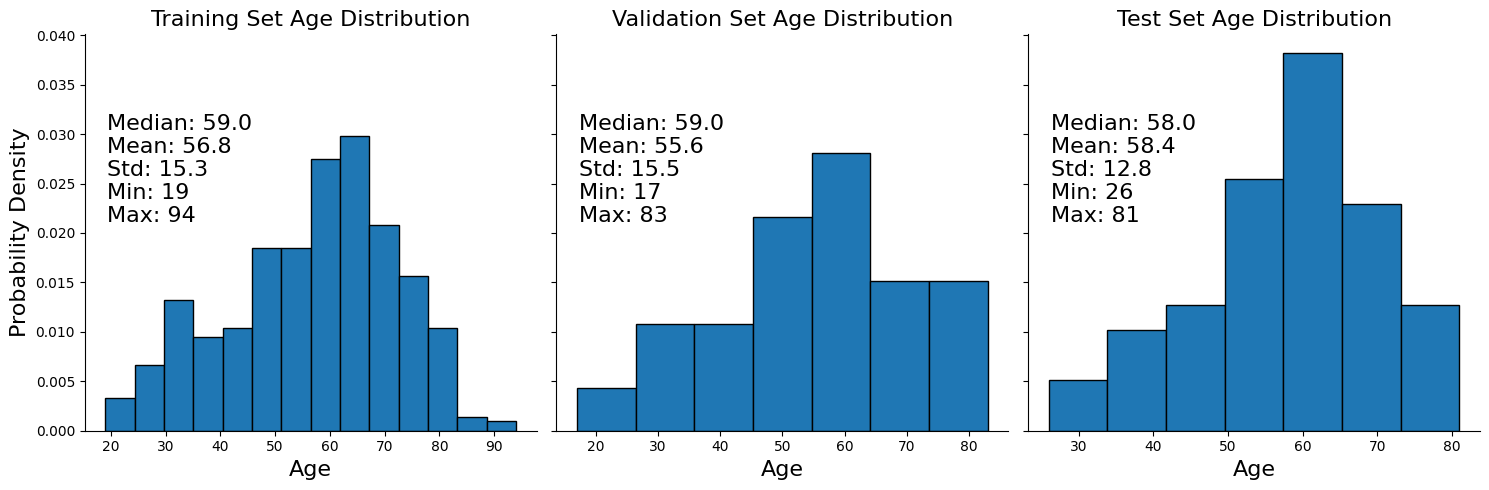

In [42]:
# Set the font size
fontsize = 16

# Create a function to calculate and display summary statistics
def display_summary_statistics(ax, data, title):
    median = np.median(data)
    mean = np.mean(data)
    std = np.std(data)
    data_min = np.min(data)
    data_max = np.max(data)

    summary_text = f'Median: {median:.1f}\nMean: {mean:.1f}\nStd: {std:.1f}\nMin: {data_min}\nMax: {data_max}'
    ax.text(0.05, 0.8, summary_text, fontsize=fontsize, ha='left', va='top', transform=ax.transAxes)

# Visualize age distribution

# Extract age data for each set
train_age_data = train_df.iloc[:, age_column_index]
validation_age_data = validation_df.iloc[:, age_column_index]
test_age_data = test_df.iloc[:, age_column_index]

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)    
    
# Create histograms for each set
ax1.hist(train_age_data, bins='auto', edgecolor='black', density=True)
ax1.set_title('Training Set Age Distribution', fontsize=fontsize)
ax1.set_xlabel('Age', fontsize=fontsize)
ax1.set_ylabel('Probability Density', fontsize=fontsize)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
display_summary_statistics(ax1, train_age_data, 'Train Set Age Distribution')

ax2.hist(validation_age_data, bins='auto', edgecolor='black', density=True)
ax2.set_title('Validation Set Age Distribution', fontsize=fontsize)
ax2.set_xlabel('Age', fontsize=fontsize)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
display_summary_statistics(ax2, validation_age_data, 'Validation Set Age Distribution')

ax3.hist(test_age_data, bins='auto', edgecolor='black', density=True)
ax3.set_title('Test Set Age Distribution', fontsize=fontsize)
ax3.set_xlabel('Age', fontsize=fontsize)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
display_summary_statistics(ax3, test_age_data, 'Test Set Age Distribution')

# Adjust the layout and display the histograms
plt.tight_layout()
filename = os.path.expanduser('~/Desktop/AgeDistribution.png')            
plt.savefig(filename, dpi=300)
plt.show()


### Next, visualize distribution of relevant attributes accros subsets

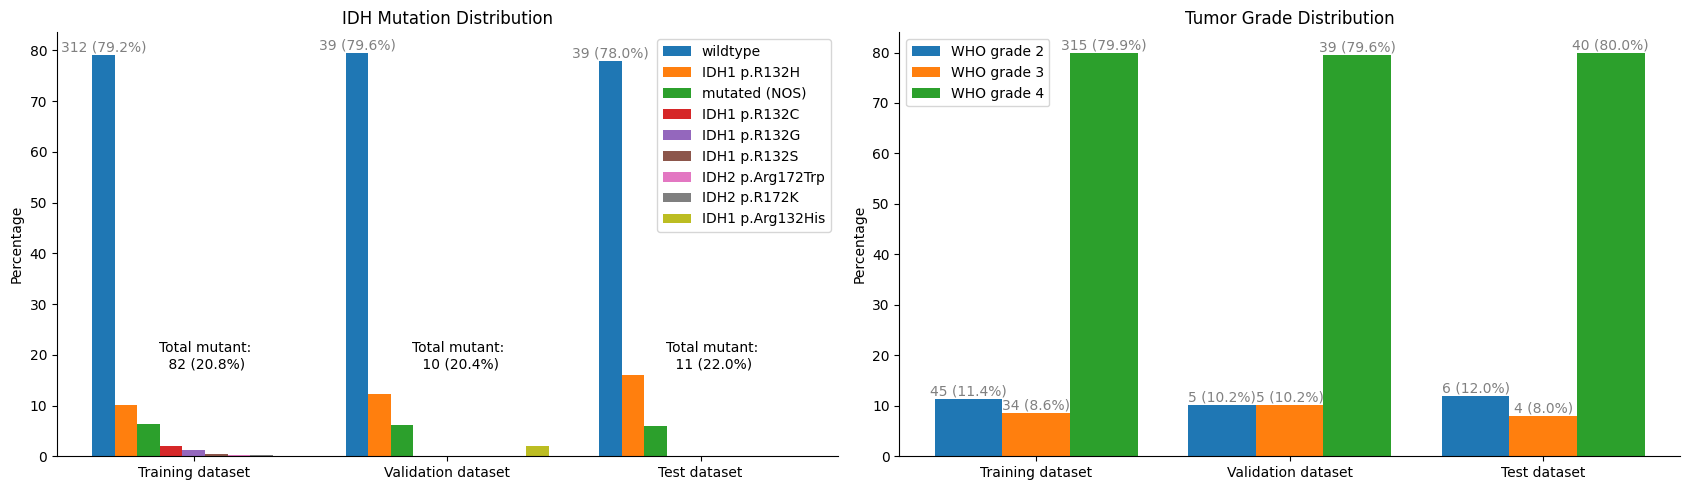

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

fontsize = 10

# Normalize countplots by calculating the percentages
def normalize_countplot(df, group_col, hue_col):
    counts = df.groupby([group_col, hue_col]).size().reset_index(name='counts')
    total_counts = df.groupby(group_col).size().reset_index(name='total_counts')
    counts = counts.merge(total_counts, on=group_col)
    counts['percentage'] = counts['counts'] / counts['total_counts'] * 100
    return counts

def sort_within_groups(df, group_col, sort_col):
    cat_dtype = pd.CategoricalDtype(['Training dataset', 'Validation dataset', 'Test dataset'], ordered=True)
    df['dataset'] = df['dataset'].astype(cat_dtype).cat.reorder_categories(['Training dataset', 'Validation dataset', 'Test dataset'])
    return df.groupby(group_col, group_keys=False).apply(lambda g: g.sort_values([sort_col, 'dataset'], ascending=[False, True]))

# Create barplot using matplotlib
def create_barplot(ax, df, group_col, hue_col, hue_order=None):
    datasets = df[group_col].unique()
    categories = df[hue_col].unique()
    width = 0.8 / len(categories)
    
    if hue_order:
        categories = hue_order

    for i, category in enumerate(categories):
        values = np.zeros(len(datasets))
        for j, dataset in enumerate(datasets):
            value = df.loc[(df[hue_col] == category) & (df[group_col] == dataset), 'percentage']
            if len(value) > 0:
                values[j] = value.values[0]
        ax.bar(np.arange(len(datasets)) + i * width, values, width=width, label=str(category))

    ax.set_xticks(np.arange(len(datasets)) + width * (len(categories) - 1) / 2)
    ax.set_xticklabels(datasets)
    ax.set_ylabel("Percentage")
    ax.legend(loc='upper right')
    
    return ax

def annotate_bars(ax, df, hue_col, target_category=None):
    unique_datasets = df['dataset'].unique()
    unique_hues = df[hue_col].unique()
    bar_width = 0.8 / len(unique_hues)

    for i, dataset in enumerate(unique_datasets):
        for j, hue in enumerate(unique_hues):
            data_row = df.loc[(df['dataset'] == dataset) & (df[hue_col] == hue)]
            if not data_row.empty:
                count = data_row['counts'].values[0]
                percentage = data_row['percentage'].values[0]
                if count > 0:
                    # Annotate only 'wildtype' bars in IDH plot, or all bars in other plots
                    if hue_col != 'IDH' or hue == 'wildtype':
                        x = i + bar_width * (j)
                        y = percentage
                        ax.annotate(f'{count} ({percentage:.1f}%)', (x, y), ha='center', va='bottom', fontsize=fontsize, color='grey')
        
        # Add "Total mutant:" text to the IDH axis
        if hue_col == 'IDH':
            total_mutant = df.loc[(df['dataset'] == dataset) & (df[hue_col] != 'wildtype')]['counts'].sum()
            percentage_mutant = 100 - df.loc[(df['dataset'] == dataset) & (df[hue_col] == 'wildtype')]['percentage'].sum()
            ax.annotate(f'Total mutant:\n {total_mutant} ({round(percentage_mutant,1)}%)', xy=(i + 0.5 * bar_width * len(unique_hues), 0.2 * ax.get_ylim()[1]), ha='center', va='bottom', fontsize=fontsize, color='black')

    return ax


# Add a new column to each DataFrame indicating the dataset it belongs to
train_df['dataset'] = 'Training dataset'
validation_df['dataset'] = 'Validation dataset'
test_df['dataset'] = 'Test dataset'


# Combine the DataFrames into one
combined_df = pd.concat([train_df, validation_df, test_df])

normalized_counts = normalize_countplot(combined_df, 'dataset', 'IDH')
normalized_tumor_grade_counts = normalize_countplot(combined_df, 'dataset', 'WHO CNS Grade')

# Sort DataFrames for axis 1 and 2 by descending percentage
normalized_counts = sort_within_groups(normalized_counts, 'dataset', 'percentage')

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

# Create IDH mutation distribution bar plot
ax1 = create_barplot(axes[0], normalized_counts, 'dataset', 'IDH')
ax1 = annotate_bars(ax1, normalized_counts, 'IDH')
ax1.set_title("IDH Mutation Distribution")

# Reorder groups of bars to Train, Val, Test
normalized_tumor_grade_counts = pd.concat([normalized_tumor_grade_counts.iloc[3:], normalized_tumor_grade_counts.iloc[:3]])

# Create tumor grade distribution bar plot
ax2 = create_barplot(axes[1], normalized_tumor_grade_counts, 'dataset', 'WHO CNS Grade')
ax2 = annotate_bars(ax2, normalized_tumor_grade_counts, 'WHO CNS Grade')
ax2.legend(['WHO grade 2', 'WHO grade 3', 'WHO grade 4'], loc='upper left')
ax2.set_title("Tumor Grade Distribution")


for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
filename = os.path.expanduser('~/Desktop/AttributeDistribution.png')            
plt.savefig(filename, dpi=300)
plt.show()

